<a href="https://colab.research.google.com/github/grams3003/ML-4430/blob/main/ML_assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import numpy as np
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
%cd 'drive/MyDrive/ML/assignment3/'

/content/drive/MyDrive/ML/assignment3


In [5]:
BATCH_SIZE = 32
transform = transforms.Compose([transforms.Resize((28,28)), transforms.Grayscale(), transforms.ToTensor()])
#transform = transforms.Compose([transforms.ToTensor()])

In [6]:
data = datasets.ImageFolder('data', transform = transform)
trainload = torch.utils.data.DataLoader(data, batch_size= BATCH_SIZE)

In [7]:
dataiter = iter(trainload)
images, labels = next(dataiter)
images[0].shape


torch.Size([1, 28, 28])

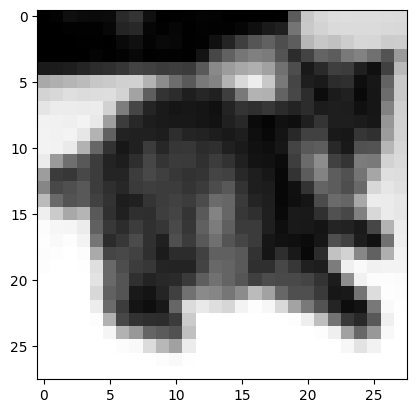

In [8]:
plt.imshow(images[5].permute(1,2,0), cmap='gray')

In [10]:
latent_dims = 10
num_epochs = 50
capacity = 32
learning_rate = 1e-3
use_gpu = True

In [11]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=2*c, kernel_size=4,stride=2, padding=1)
        self.fc = nn.Linear(in_features=2*c*7*7, out_features=latent_dims)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [12]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=2*c*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=2*c, out_channels=c, kernel_size=4, stride=2, padding=1)
        # self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=c//2, kernel_size=4, stride=2, padding=1)
        # self.conv0 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)
        
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2,7,7)
        x = F.relu(self.conv2(x))
        # x = F.relu(self.conv1(x))
        # x = torch.tanh(self.conv0(x))
        x = torch.tanh(self.conv1(x))
        return x
        

In [13]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon

In [14]:
autoencoder = Autoencoder()

device = torch.device('cuda:0' if use_gpu and torch.cuda.is_available() else 'cpu')
autoencoder = autoencoder.to(device)

num_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 132555


In [ ]:
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)

autoencoder.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, _ in trainload:
        image_batch = image_batch.to(device)
        
        image_batch_recon = autoencoder(image_batch)
        
        loss = F.mse_loss(image_batch_recon, image_batch)
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
    
    train_loss_avg[-1] /= num_batches
    # print('Epoch [%d / %d] average reconstruction error: %f' % epoch+1, num_epochs, train_loss_avg[-1])
    print('Epoch [{} / {}] average reconstruction error: {}'.format(epoch+1, num_epochs, train_loss_avg[-1]))

In [ ]:
autoencoder.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, _ in trainload:
    
    with torch.no_grad():
        image_batch = image_batch.to(device)
        
        image_batch_recon = autoencoder(image_batch)
        
        loss = F.mse_loss(image_batch_recon, image_batch)
        
        test_loss_avg += loss.item()
        num_batches += 1

test_loss_avg /= num_batches
print('average reconstruction error: {}'.format(test_loss_avg))

In [ ]:
plt.ion()

autoencoder.eval()

def to_img(x):
    x = .5 * (x+1)
    x = x.clamp(0,1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

def visualize_output(images, model):
    with torch.no_grad():
        
        images = images.to(device)
        images = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:4], 2,3).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1,2,0)))
        plt.show()

dataiter = iter(trainload)
images, labels = next(dataiter)

print('Original images')
show_image(torchvision.utils.make_grid(images[1:4],2,3))
plt.show()

print('Autoencoder reconstruction:')
visualize_output(images, autoencoder)